# Electricity Production Forecasting

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('Electric_Production.csv',index_col='DATE')

In [3]:
data.columns=['Prod']
data.head()

,Prod
DATE,
1/1/1985,72.5052
2/1/1985,70.6720
3/1/1985,62.4502
4/1/1985,57.4714
5/1/1985,55.3151


In [4]:
# make index time series

data.index = pd.to_datetime(data.index)

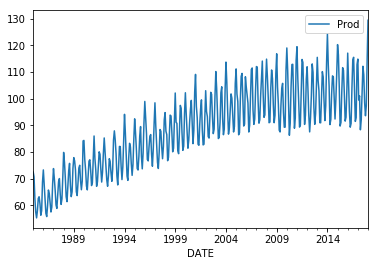

In [5]:
data.plot()

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1985-01-01 to 2018-01-01
Data columns (total 1 columns):
Prod    397 non-null float64
dtypes: float64(1)
memory usage: 6.2 KB


In [7]:
# train test split, not randomly splitted

train = data.head(300)
test = data.tail(97)

In [8]:
# scale the data
# only fit_transform on train set, then transform the test data. DO NOT DO FIT_TRANSFORM ON TEST SET

from sklearn.preprocessing import MinMaxScaler

In [9]:
scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train)

test_scaled = scaler.transform(test)

In [10]:
# create a batch function

In [11]:
def next_batch(training_data,batch_size,steps):
    
    
    # Grab a random starting point for each batch
    rand_start = np.random.randint(0,len(training_data)-steps) 

    # Create Y data for time series in the batches
    y_batch = np.array(training_data[rand_start:rand_start+steps+1]).reshape(1,steps+1)

    return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) 

## Setting up RNN model

In [12]:
import tensorflow as tf

In [13]:
# define the constants

# Just one feature, the time series
num_inputs = 1
# Num of steps in each batch
num_time_steps = 20
# 100 neuron layer, play with this
num_neurons = 100
# Just one output, predicted time series
num_outputs = 1

## You can also try increasing iterations, but decreasing learning rate
# learning rate you can play with this
learning_rate = 0.005 
# how many iterations to go through (training steps), you can play with this
num_train_iterations = 4000
# Size of the batch of data
batch_size = 1

In [14]:
# create placeholders

X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

In [15]:
# create an RNN cell

cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs) 

W0718 15:05:51.577849  1380 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0718 15:05:51.579848  1380 deprecation.py:323] From <ipython-input-15-dfd81c129480>:4: BasicLSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


In [16]:
# pass in the cells variable into tf.nn.dynamic_rnn, along with your first placeholder (X)

outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

W0718 15:05:51.590840  1380 deprecation.py:323] From <ipython-input-16-7832ae01ccff>:3: dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
W0718 15:05:51.827694  1380 deprecation.py:506] From C:\Users\Ömer\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0718 15:05:51.845684  1380 deprecation.py:506] From C:\Users\Ömer\Anaconda3\lib\site-packages\tensorflow\python\ops\rnn_cell_impl.py:738: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with th

In [17]:
# define training

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

In [18]:
# initialize variables

init = tf.global_variables_initializer()

In [19]:
saver = tf.train.Saver()

In [20]:
with tf.Session() as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = next_batch(train_scaled,batch_size,num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    # Save Model for Later
    saver.save(sess, "./ex_time_series_model")

0 	MSE: 0.05080558
100 	MSE: 0.015891721
200 	MSE: 0.013106915
300 	MSE: 0.008783649
400 	MSE: 0.004511349
500 	MSE: 0.0044323923
600 	MSE: 0.0038714434
700 	MSE: 0.005187447
800 	MSE: 0.0019849667
900 	MSE: 0.0020915691
1000 	MSE: 0.0024418875
1100 	MSE: 0.0039468864
1200 	MSE: 0.0037489864
1300 	MSE: 0.0031972197
1400 	MSE: 0.007969781
1500 	MSE: 0.00439479
1600 	MSE: 0.0037204803
1700 	MSE: 0.005130212
1800 	MSE: 0.0021624814
1900 	MSE: 0.0054068035
2000 	MSE: 0.0017872311
2100 	MSE: 0.0044366736
2200 	MSE: 0.0009898894
2300 	MSE: 0.0028901182
2400 	MSE: 0.004636138
2500 	MSE: 0.006477577
2600 	MSE: 0.004950469
2700 	MSE: 0.0012853683
2800 	MSE: 0.0031025277
2900 	MSE: 0.0029553878
3000 	MSE: 0.0028860501
3100 	MSE: 0.0031950332
3200 	MSE: 0.0030480232
3300 	MSE: 0.0021631452
3400 	MSE: 0.0025931345
3500 	MSE: 0.0016200127
3600 	MSE: 0.0030762865
3700 	MSE: 0.002584538
3800 	MSE: 0.0064445576
3900 	MSE: 0.00447687


## Time to Predict

In [21]:
test.head()

,Prod
DATE,
2010-01-01,119.0166
2010-02-01,110.5330
2010-03-01,98.2672
2010-04-01,86.3000
2010-05-01,90.8364


In [22]:
with tf.Session() as sess:
    
    # Use your Saver instance to restore your saved rnn time series model
    saver.restore(sess, "./ex_time_series_model")

    # Create a numpy array for your genreative seed from the last 12 months of the 
    # training set data. Hint: Just use tail(12) and then pass it to an np.array
    train_seed = list(train_scaled[-97:])
    
    ## Now create a for loop that 
    for iteration in range(12):
        X_batch = np.array(train_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        train_seed.append(y_pred[0, -1, 0])

W0718 15:06:20.619713  1380 deprecation.py:323] From C:\Users\Ömer\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [23]:
# show the results of predictions

train_seed

[array([0.61321759]),
 array([0.77508311]),
 array([0.64848293]),
 array([0.61675323]),
 array([0.4954752]),
 array([0.48637357]),
 array([0.61568035]),
 array([0.76528899]),
 array([0.75287443]),
 array([0.61761966]),
 array([0.51344111]),
 array([0.5406647]),
 array([0.73939837]),
 array([0.89188429]),
 array([0.78883226]),
 array([0.63784676]),
 array([0.4835597]),
 array([0.49011566]),
 array([0.58132371]),
 array([0.76247673]),
 array([0.79902303]),
 array([0.61119212]),
 array([0.50701194]),
 array([0.54064194]),
 array([0.78397991]),
 array([0.94946071]),
 array([0.82650834]),
 array([0.65165931]),
 array([0.51056546]),
 array([0.54806597]),
 array([0.6533109]),
 array([0.75556477]),
 array([0.72968065]),
 array([0.62924419]),
 array([0.52361724]),
 array([0.55756261]),
 array([0.81947445]),
 array([0.90782636]),
 array([0.75531605]),
 array([0.70942593]),
 array([0.50657141]),
 array([0.51869498]),
 array([0.7183845]),
 array([0.86212642]),
 array([0.88059464]),
 array([0.71201

In [24]:
# reshape the results to add test set easily
results = scaler.inverse_transform(np.array(train_seed[12:]).reshape(97,1))

In [25]:
test['Generated'] = results

C:\Users\Ömer\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [26]:
test

,Prod,Generated
DATE,,
2010-01-01,119.0166,100.800300
2010-02-01,110.5330,110.180700
2010-03-01,98.2672,103.841300
2010-04-01,86.3000,94.553200
2010-05-01,90.8364,85.062000
2010-06-01,104.3538,85.465300
2010-07-01,112.8066,91.076100
2010-08-01,112.9014,102.220000
2010-09-01,100.1209,104.468200


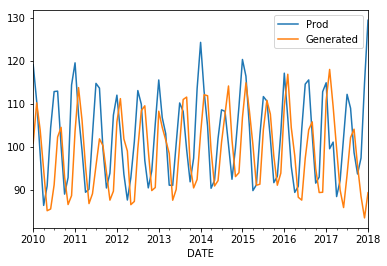

In [27]:
test.plot()